In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
!pip install bar_chart_race
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 163kB 7.7MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
covid_df = pd.read_csv(url)

In [ ]:
covid_df['datestamp'] = [datetime.strptime(d,'%Y-%m-%d') for d in covid_df.date]

all_countries = pd.DataFrame(index=covid_df.iso_code.unique())
cases_start_date = covid_df[(covid_df.total_cases > 10000)].groupby('iso_code').datestamp.min().to_frame()
deaths_start_date = covid_df[(covid_df.total_deaths > 100)].groupby('iso_code').datestamp.min().to_frame()
all_countries['iso_code'] = all_countries.index
all_countries['cases_start_date'] = cases_start_date
all_countries['deaths_start_date'] = deaths_start_date
covid_df = pd.merge(covid_df,all_countries,how='left',on='iso_code')
covid_df.loc[covid_df.cases_start_date.isna(),covid_df.columns=='cases_start_date'] = datetime(datetime.today().year,12,31)
covid_df.loc[covid_df.deaths_start_date.isna(),covid_df.columns=='deaths_start_date'] = datetime(datetime.today().year,12,31)

covid_df['days_since_100_deaths'] = (covid_df.datestamp - covid_df.deaths_start_date).astype(int)/(24*60*60*10e8)
covid_df['days_since_10000_cases'] = (covid_df.datestamp - covid_df.cases_start_date).astype(int)/(24*60*60*10e8)

covid_df.drop(columns = ['cases_start_date','deaths_start_date'])

inc_df = pd.DataFrame(columns=['date','iso_code','new_cases_per_million'])
dates = covid_df.date.unique()
dates = np.sort(dates)
for i,d in enumerate(dates):
  inc_d = (covid_df[covid_df.datestamp.between(dates[max(i-14,0)],d)].groupby('iso_code').new_cases_per_million.sum()/10).to_frame()
  inc_d['date'] = d;inc_d['iso_code'] = inc_d.index;
  inc_df = pd.concat([inc_df,inc_d])
inc_df = inc_df.rename(columns={'new_cases_per_million':'14-day-incidence-rate-per-100000'})

covid_df = pd.merge(left=covid_df,right=inc_df,on=['date','iso_code'],how='left')


# Cases and deaths worldwide

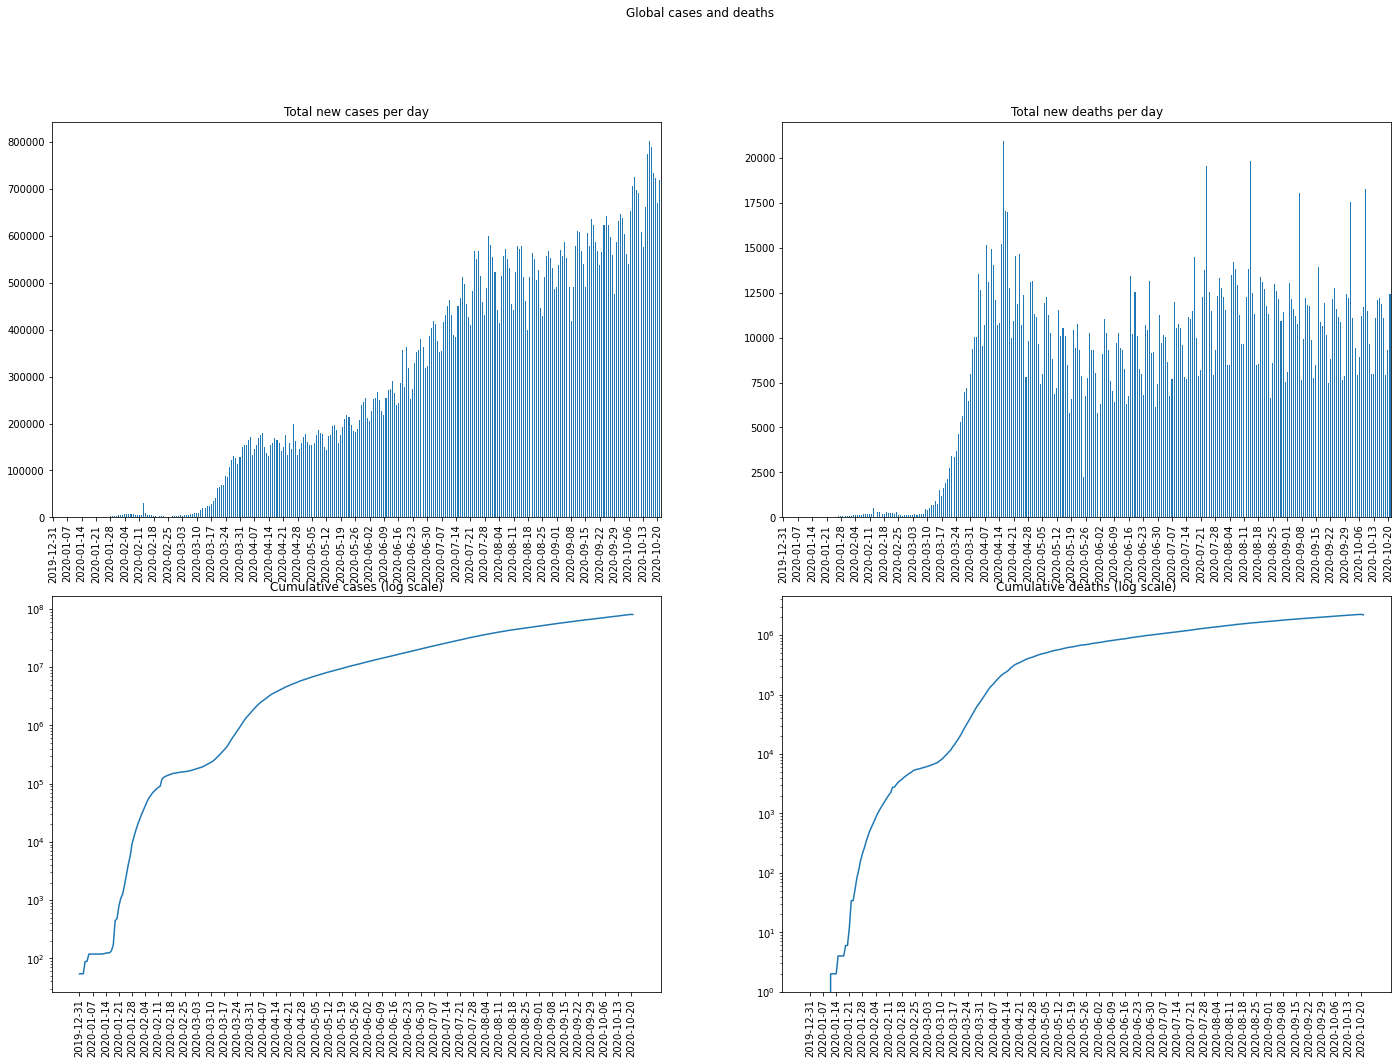

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(24,16))

covid_df.groupby('date').new_cases.sum().plot(kind='bar',title='Total new cases per day',ax=axs[0][0])
axs[0][0].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][0].xaxis.set_label_text('');
covid_df.groupby('date').new_deaths.sum().plot(kind='bar',title='Total new deaths per day',ax=axs[0][1])
axs[0][1].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][1].xaxis.set_label_text('');

covid_df.groupby('date').total_cases.sum().plot(title='Cumulative cases (log scale)',ax=axs[1][0])
axs[1][0].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90)
axs[1][0].xaxis.set_label_text('');

axs[1][0].set_yscale('log')
covid_df.groupby('date').total_deaths.sum().plot(title='Cumulative deaths (log scale)',ax=axs[1][1])
axs[1][1].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90);
axs[1][1].set_yscale('log')
axs[1][1].xaxis.set_label_text('');
fig.suptitle('Global cases and deaths');

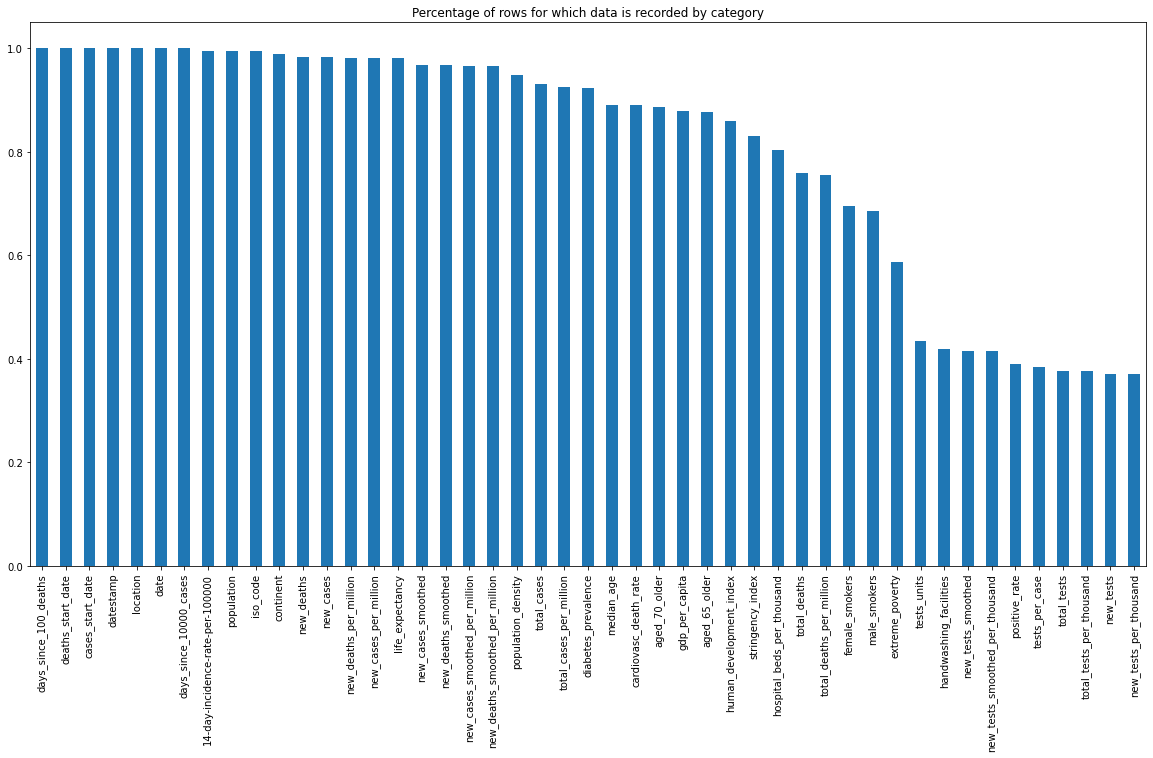

In [ ]:
#'Data to do with testing is poorly reported'
column_fill_rate =  (1-covid_df.isna().sum()/covid_df.shape[0])
column_fill_rate.sort_values(ascending=False).plot(kind='bar',figsize=(20,10));
plt.title('Percentage of rows for which data is recorded by category');

# Scatter of tests per million vs deaths per million by country

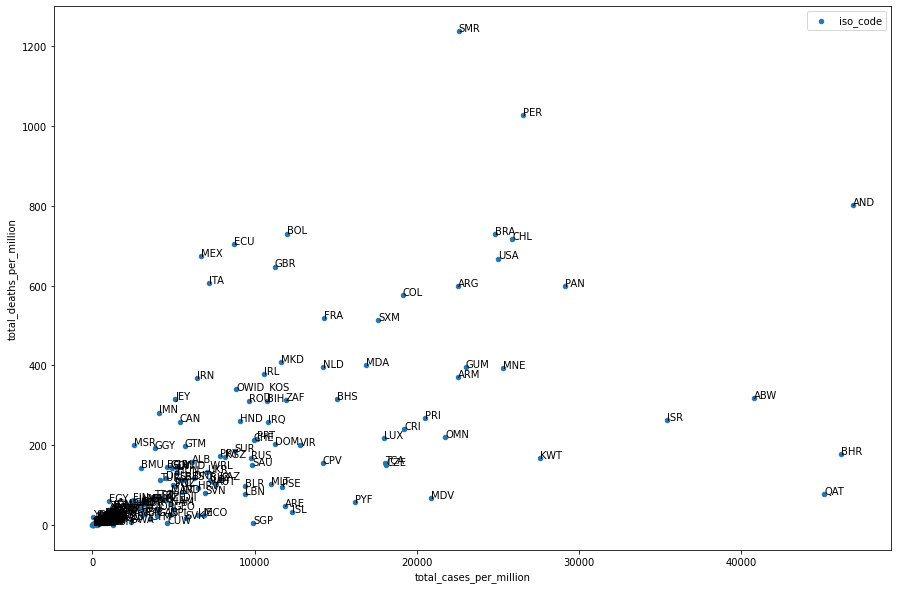

In [ ]:
ax = covid_df.loc[covid_df.date == covid_df.date.max(),:].plot(x='total_cases_per_million',
                                                               y='total_deaths_per_million',
                                                               kind='scatter',
                                                               figsize=(15,10),
                                                               label='iso_code')
for r in covid_df.loc[covid_df.date == covid_df.date.max(),:].iterrows():
    ax.annotate(r[1].iso_code, (r[1].total_cases_per_million, r[1].total_deaths_per_million))


# Deaths per million by country

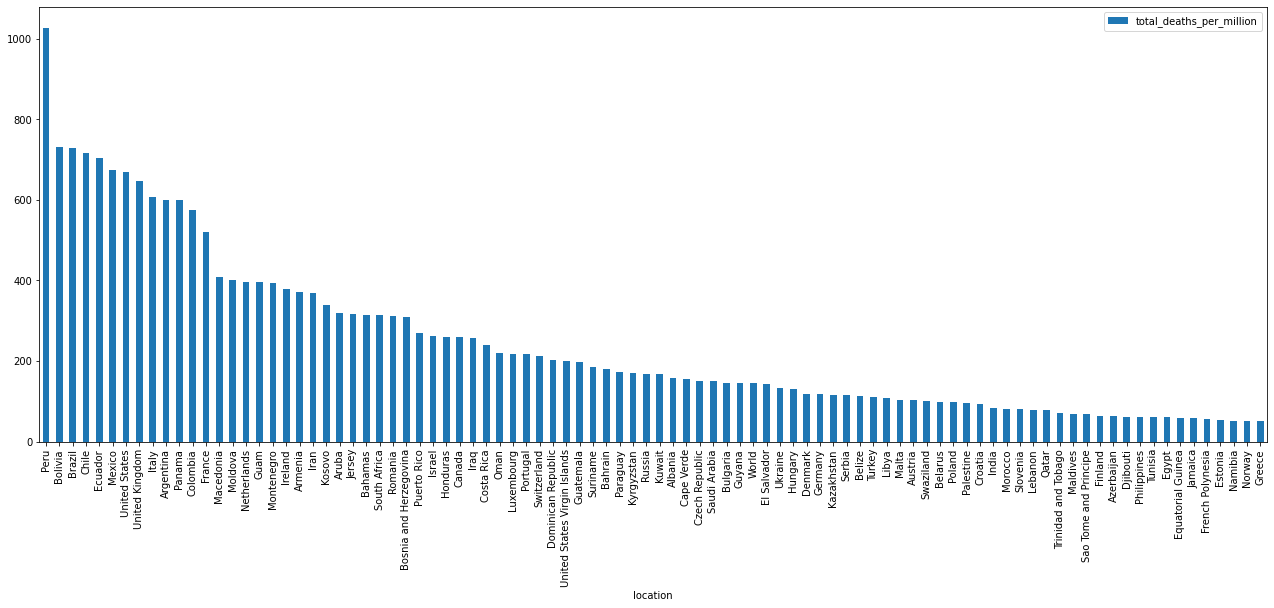

In [ ]:
#covid_df.loc[covid_df.date == dates[-1],:].plot(x='iso_code',y='total_deaths_per_million',kind='bar',figsize=(22,8));
covid_df.loc[(covid_df.date == dates[-1])&(covid_df.total_deaths_per_million>50)&(covid_df.population>100000),:].sort_values('total_deaths_per_million',ascending=False).plot(
    x='location',y='total_deaths_per_million',kind='bar',figsize=(22,8));

# Deaths per case by country

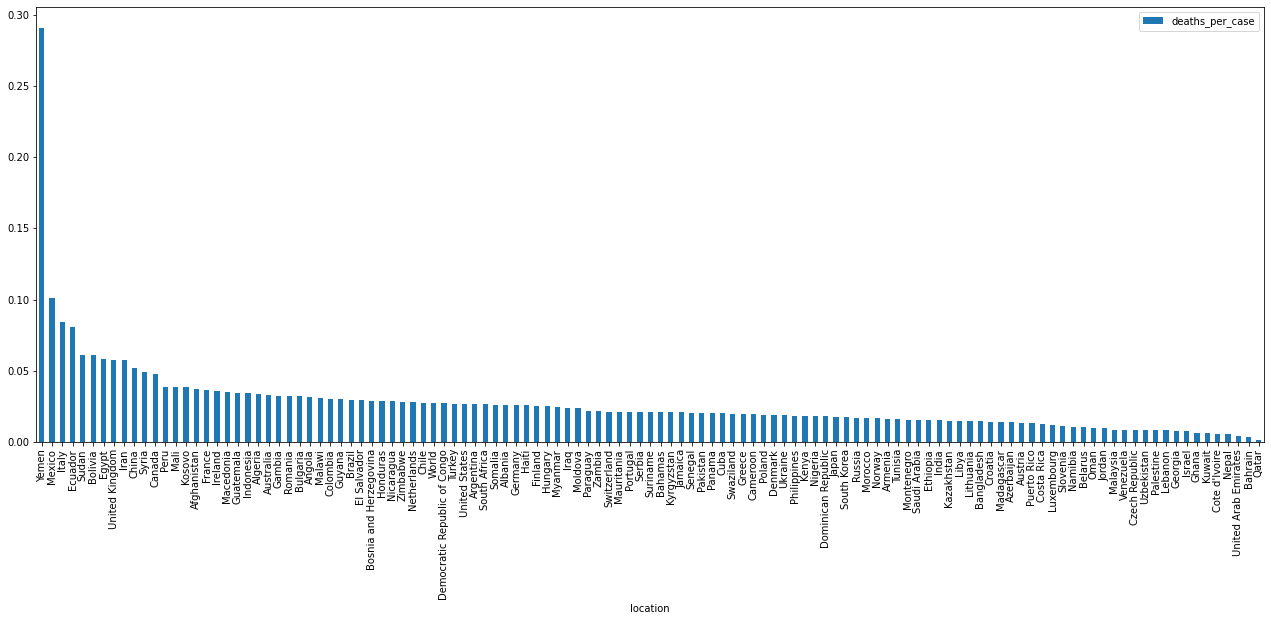

In [ ]:
covid_df['deaths_per_case'] = covid_df.total_deaths_per_million/covid_df.total_cases_per_million
covid_df.loc[(covid_df.date == dates[-1])&(covid_df.population>100000)&(covid_df.total_deaths>100),:].sort_values('deaths_per_case',ascending=False).plot(
    x='location',y='deaths_per_case',kind='bar',figsize=(22,8));


# Testing rate by country

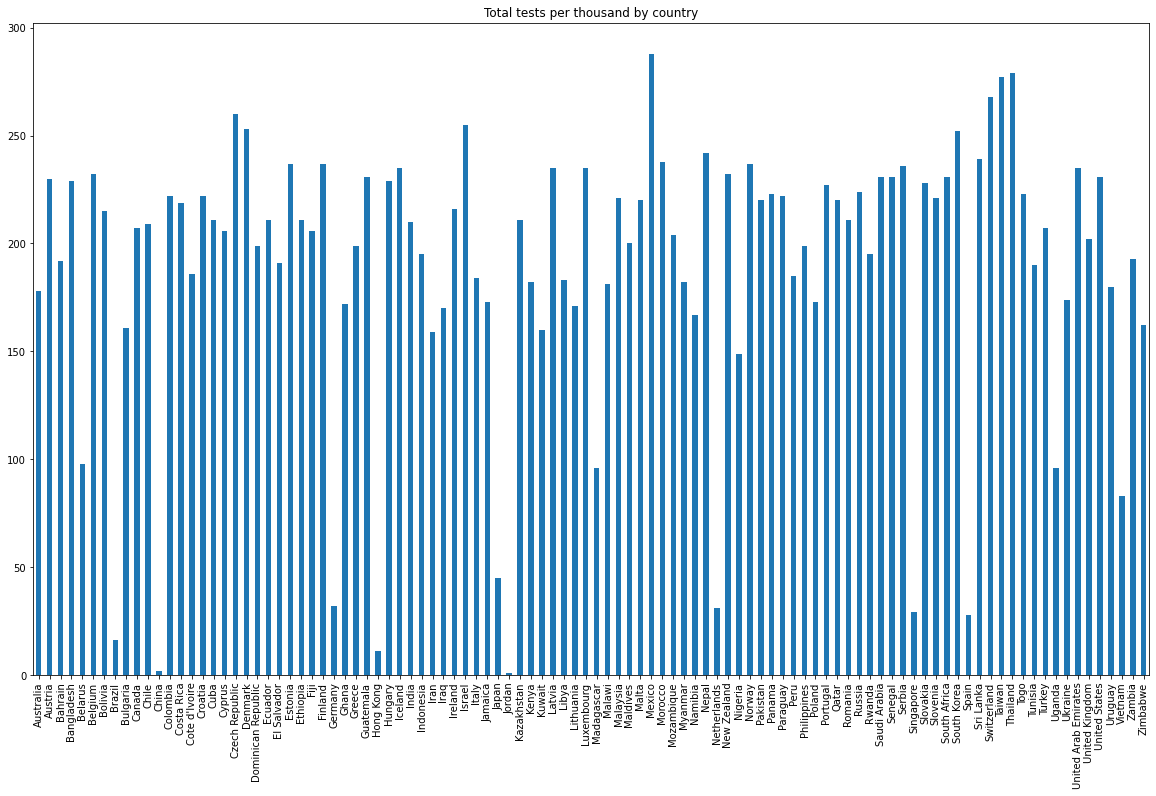

In [ ]:
covid_df.loc[~covid_df.total_tests_per_thousand.isna(),:].groupby('location').total_tests_per_thousand.count().plot(kind='bar',figsize=(20,12));
plt.xlabel('');
plt.title('Total tests per thousand by country');

# 14 day incidence rate per 100,000

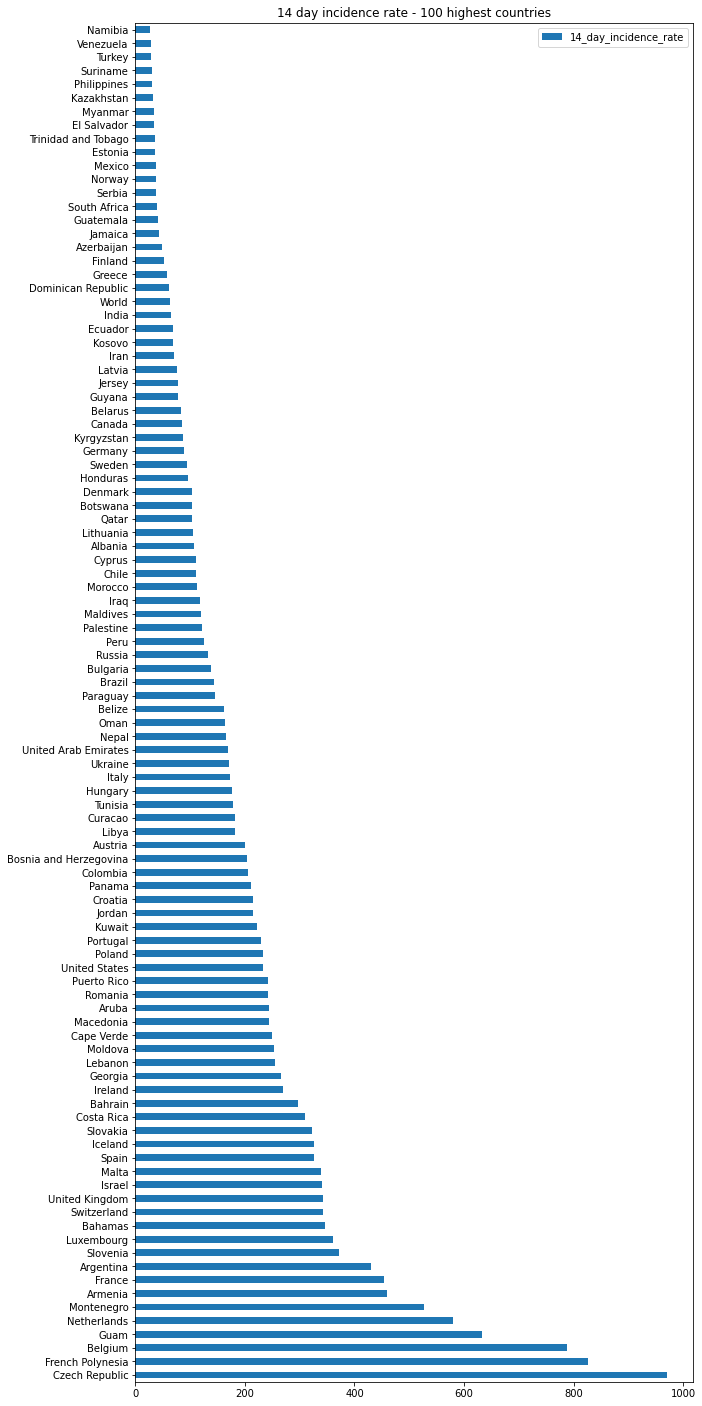

In [ ]:
sorted_dates = np.sort(covid_df.datestamp.unique())
fourteen_day_incidence = covid_df[(covid_df.population > 100000) & (covid_df.datestamp.isin(sorted_dates[-14:]))].groupby('location').agg({'new_cases_per_million':'sum'})/10
fourteen_day_incidence = fourteen_day_incidence.rename(columns={'new_cases_per_million':'14_day_incidence_rate'})
fourteen_day_incidence = fourteen_day_incidence.sort_values(by='14_day_incidence_rate',ascending=False)
fig,ax = plt.subplots(figsize=(10,25));
fourteen_day_incidence[:100].plot(kind='barh',ax=ax);
plt.ylabel('');plt.title('14 day incidence rate - 100 highest countries');

# 14 day incidence rate by continent


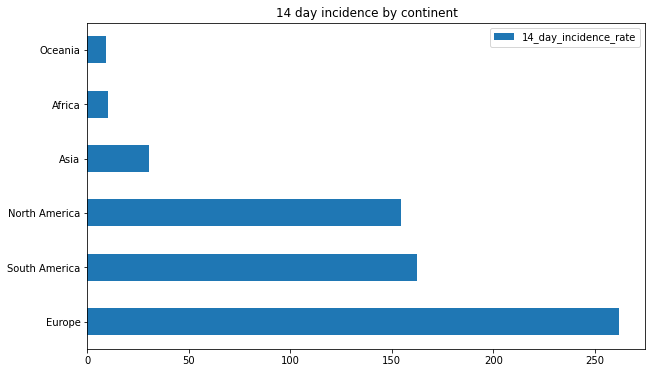

In [ ]:
fourteen_day_incidence = covid_df[covid_df.datestamp.isin(sorted_dates[-14:])].groupby('continent').agg({'new_cases':'sum'})
population = covid_df[covid_df.datestamp.isin(sorted_dates[-1:])].groupby('continent').agg({'population':'sum'})
fourteen_day_incidence = pd.merge(left=fourteen_day_incidence,right=population,on='continent')
fourteen_day_incidence['14_day_incidence_rate'] = fourteen_day_incidence.new_cases/(fourteen_day_incidence.population/100000)
fourteen_day_incidence = fourteen_day_incidence.sort_values(by='14_day_incidence_rate',ascending=False)
fig,ax = plt.subplots(figsize=(10,6));
fourteen_day_incidence[:100].plot(y='14_day_incidence_rate',kind='barh',ax=ax);
plt.ylabel('');plt.title('14 day incidence by continent');

# Cases and deaths single country



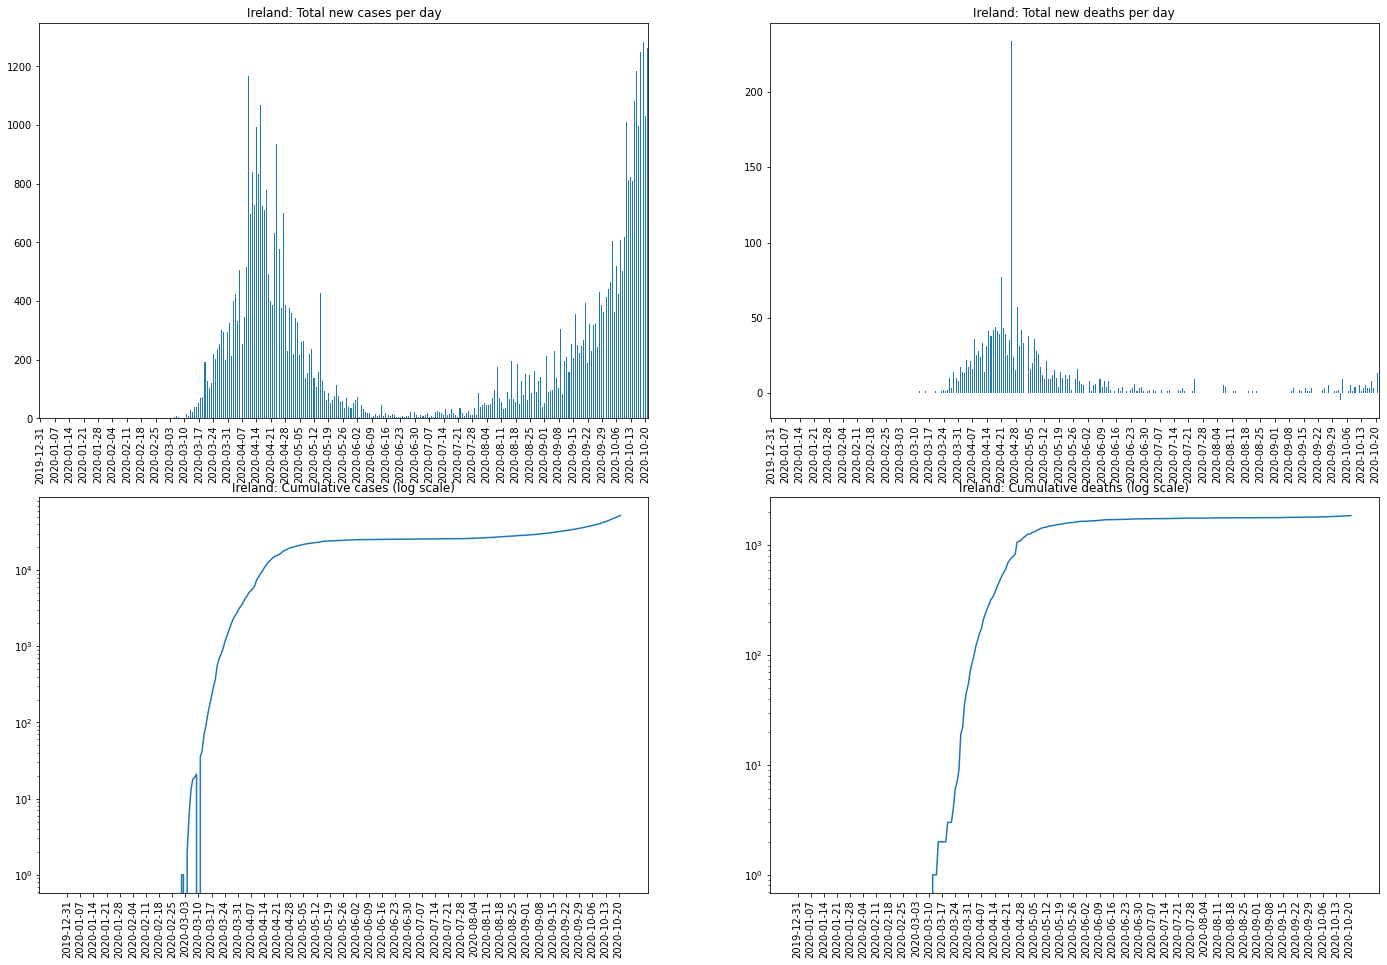

In [ ]:
iso = 'IRL'
country_df = covid_df[covid_df.iso_code==iso]
country_name = country_df.location.values[0]
dates = country_df.date.unique()
dates = np.sort(dates)
fig,axs = plt.subplots(2,2,figsize=(24,16))

country_df.groupby('date').new_cases.sum().plot(kind='bar',title=country_name+': Total new cases per day',ax=axs[0][0])
axs[0][0].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][0].xaxis.set_label_text('');
country_df.groupby('date').new_deaths.sum().plot(kind='bar',title=country_name+': Total new deaths per day',ax=axs[0][1])
axs[0][1].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][1].xaxis.set_label_text('');

country_df.groupby('date').total_cases.sum().plot(title=country_name+': Cumulative cases (log scale)',ax=axs[1][0])
axs[1][0].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90)
axs[1][0].set_yscale('log')
axs[1][0].xaxis.set_label_text('');
country_df.groupby('date').total_deaths.sum().plot(title=country_name+': Cumulative deaths (log scale)',ax=axs[1][1])
axs[1][1].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90);
axs[1][1].set_yscale('log')
axs[1][1].xaxis.set_label_text('');


# Comparing the evolution in multiple countries




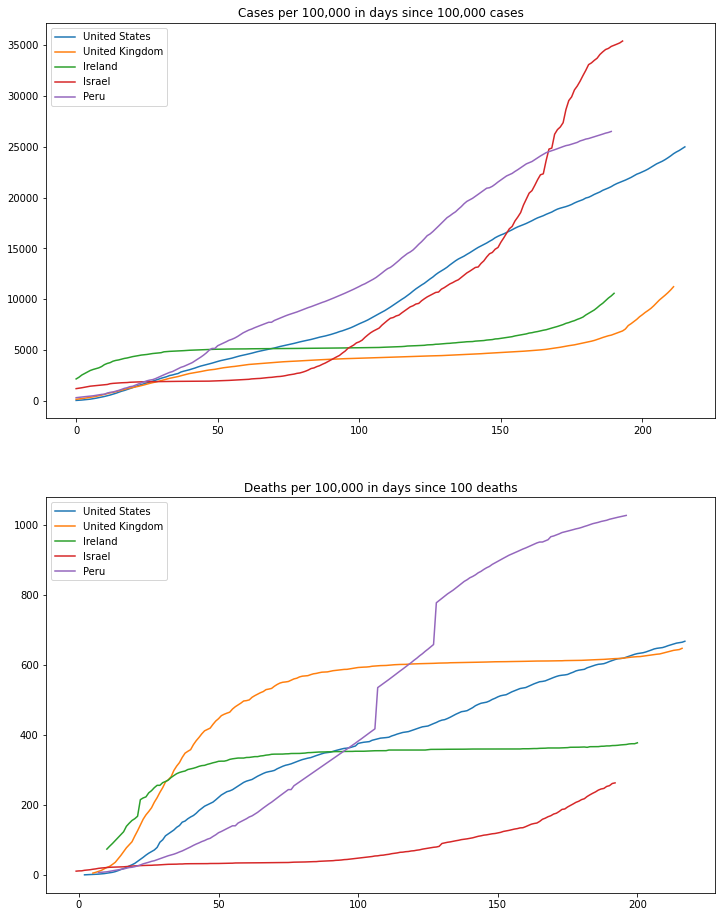

In [ ]:
iso_list = ['USA','GBR','IRL','ISR','PER']
loc_list = [covid_df[covid_df.iso_code == i].location.values[0] for i in iso_list]
cases_df = covid_df[(covid_df.iso_code.isin(iso_list))&(covid_df.days_since_10000_cases>=0)]
cases_plot_data = cases_df.groupby(['location','days_since_10000_cases']).total_cases_per_million.min()
deaths_df = covid_df[(covid_df.iso_code.isin(iso_list))&(covid_df.days_since_100_deaths>=0)]
deaths_plot_data = cases_df.groupby(['location','days_since_100_deaths']).total_deaths_per_million.min()
fig,axs = plt.subplots(2,1,figsize=(12,16))
for l in loc_list:
  cases_plot_data[l].plot(ax=axs[0]);
axs[0].legend(loc_list);
for l in loc_list:
  deaths_plot_data[l].plot(ax=axs[1]);
axs[1].legend(loc_list);
axs[0].set_title('Cases per 100,000 in days since 100,000 cases');axs[0].xaxis.set_label_text('');
axs[1].set_title('Deaths per 100,000 in days since 100 deaths');axs[1].xaxis.set_label_text('');

# Positive test rates


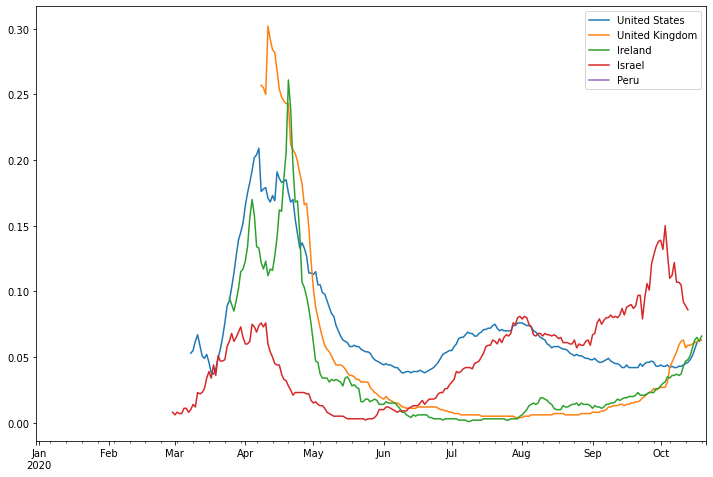

In [ ]:
iso_list = ['USA','GBR','IRL','ISR','PER']
loc_list = [covid_df[covid_df.iso_code == i].location.values[0] for i in iso_list]
pos_rate_df =  covid_df[covid_df.iso_code.isin(iso_list)].groupby([
    'location','datestamp']).positive_rate.max()

fig,ax = plt.subplots(1,1,figsize=(12,8))
for l in loc_list:
  pos_rate_df[l].plot(ax=ax);
ax.legend(loc_list);
plt.xlabel('');

# Evolution by continent


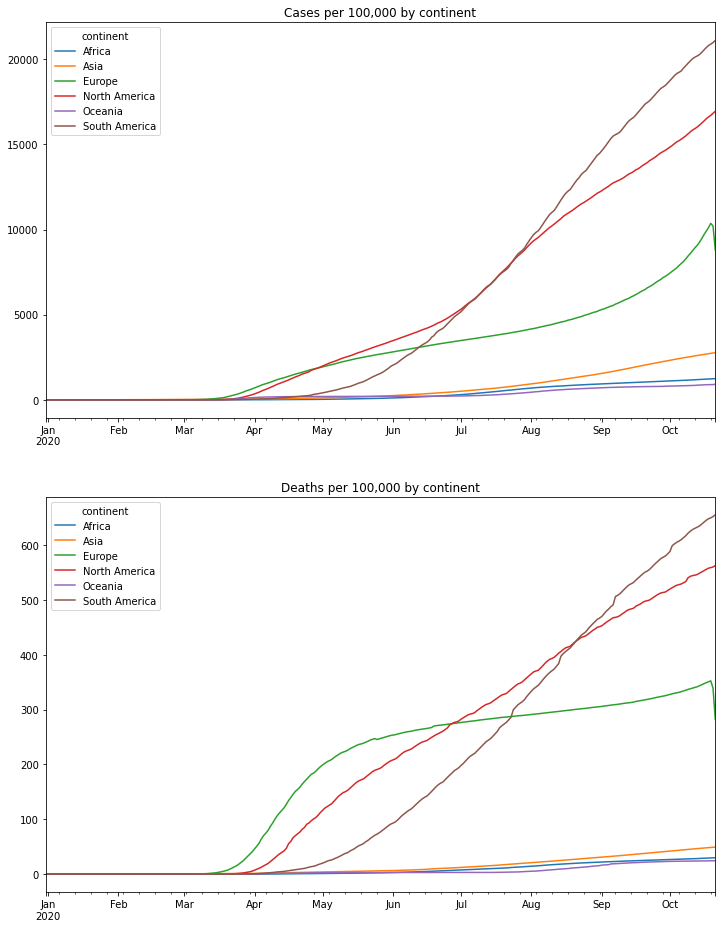

In [ ]:
continent_df = covid_df.groupby(['continent','datestamp']).agg({'total_cases':'sum','total_deaths':'sum'}).unstack()
fig,axs = plt.subplots(2,1,figsize=(12,16))
for c in population.index:
  (continent_df.loc[continent_df.index==c,'total_cases'].transpose()/
    population.loc[c].population*1000000).plot(ax=axs[0])
  (continent_df.loc[continent_df.index==c,'total_deaths'].transpose()/
    population.loc[c].population*1000000).plot(ax=axs[1])

axs[0].set_title('Cases per 100,000 by continent');axs[0].xaxis.set_label_text('');
axs[1].set_title('Deaths per 100,000 by continent');axs[1].xaxis.set_label_text('');

# How the virus spread

In [ ]:
cov_df = covid_df[~covid_df.iso_code.isna()]
cov_df.iso_code.unique()
colors = dict(zip(
    ['North America','South America','Europe','Asia','Africa','Oceania','World'],
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381', '#aafbff', '#f7bb5f','#eafb50']
))
cov_df = cov_df[cov_df.continent.isin(colors.keys())]
cov_df = cov_df[cov_df.population>1000000]
cov_df.total_cases_per_million = cov_df.total_cases_per_million.fillna(0)
cov_df.total_deaths_per_million = cov_df.total_deaths_per_million.fillna(0)

# this is a bit messy - filling missing dates
cpm = cov_df.groupby(['iso_code','date']).total_cases_per_million.max().unstack()
dpm = cov_df.groupby(['iso_code','date']).total_deaths_per_million.max().unstack()
ir = cov_df.groupby(['iso_code','date'])['14-day-incidence-rate-per-100000'].max().unstack()
for c in cpm.index:
  cpm.loc[c,:] = cpm.loc[c,:].fillna(method='ffill')
  dpm.loc[c,:] = dpm.loc[c,:].fillna(method='ffill')
  ir.loc[c,:] = ir.loc[c,:].fillna(method='ffill')
cpm = cpm.stack().reset_index();dpm = dpm.stack().reset_index();ir = ir.stack().reset_index();
cpm = cpm.rename(columns={0:'total_cases_per_million'})
dpm = dpm.rename(columns={0:'total_deaths_per_million'})
ir = ir.rename(columns={0:'14-day-incidence-rate-per-100000'})

cov_df = pd.merge(left=cpm,right=dpm,on=['iso_code','date'],how='outer')
cov_df = pd.merge(left=cov_df,right=ir,on=['iso_code','date'],how='outer')
loc_key = covid_df[['iso_code','location','continent']].drop_duplicates();
loc_key.loc[loc_key.iso_code.eq('OWID_WRL'),'continent'] = 'World'
cov_df = pd.merge(left=cov_df,right=loc_key,on='iso_code',how='right')
cov_df = cov_df[~cov_df.date.isna()]

In [ ]:
def draw_barchart_14_day(date):
    dff = cov_df.loc[cov_df['date'].eq(date),:].sort_values(by='14-day-incidence-rate-per-100000', ascending=True).tail(15)
    ax.clear()
    ax.barh(dff['iso_code'], dff['14-day-incidence-rate-per-100000'],
            color = [colors[r[1].continent] for r in dff.iterrows()])
    dx = dff['14-day-incidence-rate-per-100000'].max() / 200
    for i, (value, name,location) in enumerate(zip(dff['14-day-incidence-rate-per-100000'], dff['iso_code'], dff['location'])):
        ax.text(value-dx, i,     name,           size=14, weight=800, ha='right', va='bottom')
        ax.text(value-dx, i-.25, location, size=8, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=500)
    ax.text(0, 1.06, '14-day-incidence-rate-per-100000', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.box(False)


def draw_barchart_cumulative_cases(date):
    dff = cov_df.loc[cov_df['date'].eq(date),:].sort_values(by='total_cases_per_million', ascending=True).tail(15)
    ax.clear()
    ax.barh(dff['iso_code'], dff['total_cases_per_million'],
            color = [colors[r[1].continent] for r in dff.iterrows()])
    dx = dff['total_cases_per_million'].max() / 200
    for i, (value, name,location) in enumerate(zip(dff['total_cases_per_million'], dff['iso_code'], dff['location'])):
        ax.text(value-dx, i,     name,           size=14, weight=800, ha='right', va='bottom')
        ax.text(value-dx, i-.25, location, size=8, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=500)
    ax.text(0, 1.06, 'total_cases_per_million', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.box(False)

def draw_barchart_cumulative_deaths(date):
    dff = cov_df.loc[cov_df['date'].eq(date),:].sort_values(by='total_deaths_per_million', ascending=True).tail(15)
    ax.clear()
    ax.barh(dff['iso_code'], dff['total_deaths_per_million'],
            color = [colors[r[1].continent] for r in dff.iterrows()])
    dx = dff['total_deaths_per_million'].max() / 200
    for i, (value, name,location) in enumerate(zip(dff['total_deaths_per_million'], dff['iso_code'], dff['location'])):
        ax.text(value-dx, i,     name,           size=14, weight=800, ha='right', va='bottom')
        ax.text(value-dx, i-.25, location, size=8, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=500)
    ax.text(0, 1.06, 'total_deaths_per_million', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    plt.box(False)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(12, 12))
#animator = animation.FuncAnimation(fig,draw_barchart_cumulative_cases, frames=dates, interval=250)
animator = animation.FuncAnimation(fig,draw_barchart_cumulative_deaths, frames=dates, interval=250)
#animator = animation.FuncAnimation(fig,draw_barchart_14_day, frames=dates, interval=250)
HTML(animator.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(12, 12))
animator = animation.FuncAnimation(fig,draw_barchart_cumulative_cases, frames=dates, interval=250)
HTML(animator.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(12, 12))
animator = animation.FuncAnimation(fig,draw_barchart_14_day, frames=dates, interval=250)
HTML(animator.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.